Суть данного проекта: оценка игрового рынка и предположительный прогноз на 2017 год для магазина, занимающегося продажей игры на разных платформах. Для этого был предоставлен набор данных (спаршеный с metacritic?) со следующими признаками:
1. Name — название игры
1. Platform — платформа
1. Year_of_Release — год выпуска
1. Genre — жанр игры
1. NA_sales — продажи в Северной Америке (миллионы долларов)
1. EU_sales — продажи в Европе (миллионы долларов)
1. JP_sales — продажи в Японии (миллионы долларов)
1. Other_sales — продажи в других странах (миллионы долларов)
1. Critic_Score — оценка критиков (максимум 100)
1. User_Score — оценка пользователей (максимум 10)
1. Rating — рейтинг от организации ESRB 

[1. Окрываю данные...](#opendata)

[1.1 Описываю проблемы в данных...](#opendatares)

[2. Предобрабатываю данные...](#preproc)

[2.1 Описываю как заполнил пропуски...](#preprocres)

[3. Провожу исследовательский анализ...](#researchanalys)

[3.1 Описываю результаты исследовательского анализа...](#researchanalysres)

[4. Определяю портрет пользователя...](#userportrait)

[4.1 Результаты опредленеия портрета пользователя по рынкам...](#userportraitres)

[5 Проверяю гипотезы...](#hypotheses)

[5.1 Результаты проверки гипотезы...](#hypothesesres)

[6. Описываю выводы по работе...](#hypothesesres)

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

<a id='opendata'></a>
<H2>Окрытие данных</H2>

Для начала необходимо открыть датасет и оценить в каких фичах есть пропуски, корректно ли приведены типы данных у фич

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.tail(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.0,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.0,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.0,0.01,0.0,NaN,NaN,NaN


In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<a id='opendatares'></a>
<H4>Выводы</H4>

В представленном наборе данных есть пропуски в полях:
- Name: 2 значения
- Year_of_Release: 269 значений
- Genre: 2 значения
- Critic_Score: 8578 значений
- User_Score: 6701 значений
- Rating: 6766 значений

Также есть проблемы с типами данных:
- Year_of_Release: представлен в float, но так как это год, то лучше представить значение в int

<a id='preproc'></a>
<H2>Предобработка данных</H2>

Для начала приведу названия фич к нижнему регистру для удобного обращения

In [6]:
games.columns = map(str.lower, games.columns)
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()

Надо исправить тип данных для года. Но для начала надо заполнить пропуски в этом поле нетипичным значением, это будет -1

In [7]:
games['year_of_release'].fillna(value=-1, inplace=True)
games['year_of_release'] = games['year_of_release'].astype('int32')

Откинем строки с проущенными значениями в имени

In [8]:
games.dropna(subset = ['name'], inplace = True)

In [9]:
games['platform'].isnull().sum()

0

Откинув строки с пустым названием игры избавился и от строк с пустым жанром, отлично 

Создаю столбец по суммарным продажам во всех регионах


In [10]:
games['all_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Закодируем категориалные переменные для поиска зависимостей для заполнения пропусков

In [11]:
le = LabelEncoder()
le.fit(games.platform)
games['platform_code'] = le.transform(games.platform)

In [12]:
le.fit(games.genre)
games['genre_code'] = le.transform(games.genre)

Отфильтруем датасет для получения полностью заполненых строк

In [13]:
 games_tst = games.query('critic_score != "NaN" and user_score != "NaN" and year_of_release != "NaN" and genre != "NaN" and rating != "NaN"')

Поиск корелляций 

In [14]:
game_stat_multi = games_tst.loc[:, ['critic_score', 'platform_code', 'genre_code', 'all_sales', 'year_of_release']]
game_stat_multi.corr()

,critic_score,platform_code,genre_code,all_sales,year_of_release
critic_score,1.000000,0.022083,0.140810,0.245507,0.013954
platform_code,0.022083,1.000000,0.018992,0.049295,-0.012701
genre_code,0.140810,0.018992,1.000000,0.007807,-0.006758
all_sales,0.245507,0.049295,0.007807,1.000000,0.017840
year_of_release,0.013954,-0.012701,-0.006758,0.017840,1.000000


Зависимостей нет, заполняю пропуски нетипичными значениями для более простой фильтрации

In [15]:
games['critic_score'].fillna(value=-1, inplace=True)

In [16]:
games['user_score'].fillna(value=-1, inplace=True)

<a id='preprocres'></a>
<H4>Выводы</H4>

Все пропуски были заполнены нетипичными значениями для последующей удобной фильтрации
Названия столбцов и значения категориальных столбцов были приведены к нижнему регистру 
Так же категориальные переменные были закодированы для поиска статисической зависимости. Но никаких зависимостей не было найдено, поэтому все пропуски были заполнены нетипичными значениями

<a id='researchanalys'></a>
<H2>Исследовательский анализ данных</H2>

Смотрю распределение количества игр по годам

In [17]:
games.groupby(['year_of_release'])['name'].count()

year_of_release
-1        269
 1980       9
 1981      46
 1982      36
 1983      17
 1984      14
 1985      14
 1986      21
 1987      16
 1988      15
 1989      17
 1990      16
 1991      41
 1992      43
 1993      60
 1994     121
 1995     219
 1996     263
 1997     289
 1998     379
 1999     338
 2000     350
 2001     482
 2002     829
 2003     775
 2004     762
 2005     939
 2006    1006
 2007    1197
 2008    1427
 2009    1426
 2010    1255
 2011    1136
 2012     653
 2013     544
 2014     581
 2015     606
 2016     502
Name: name, dtype: int64

Начиная с 91 года по 02 количство игр растет, пик выпуска игр был в 08-09 годах

In [18]:
platform_name = games.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales').query('all_sales>259').reset_index()['platform'].tolist()

In [19]:
df_for_graph = games.query('year_of_release>0').pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum').reset_index()

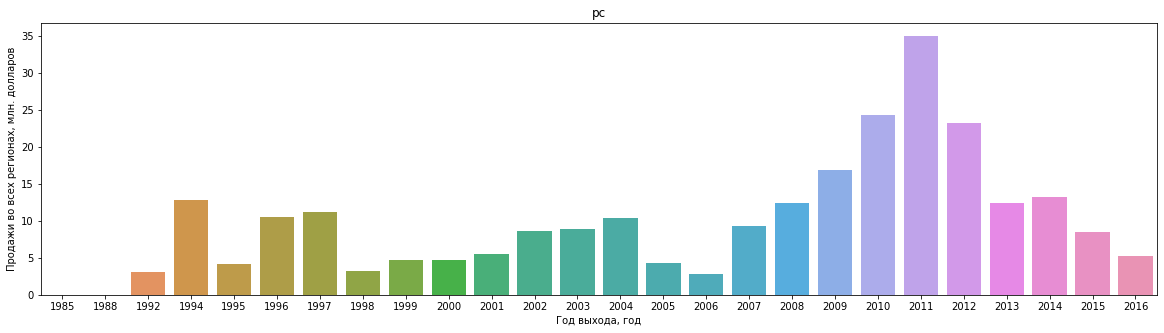

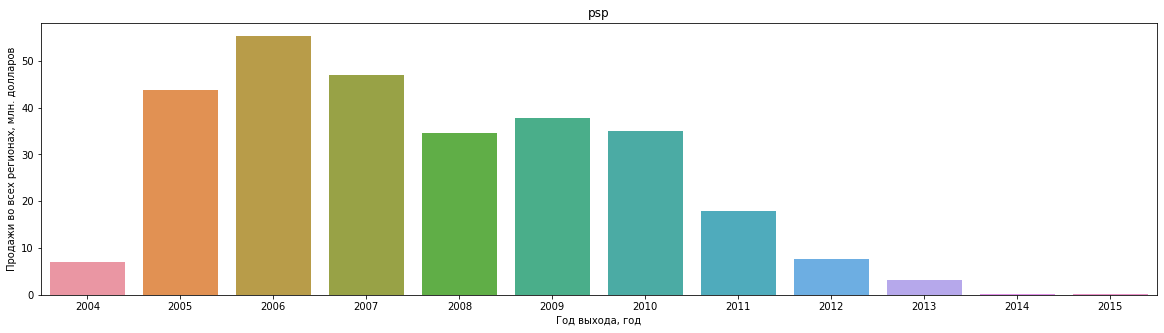

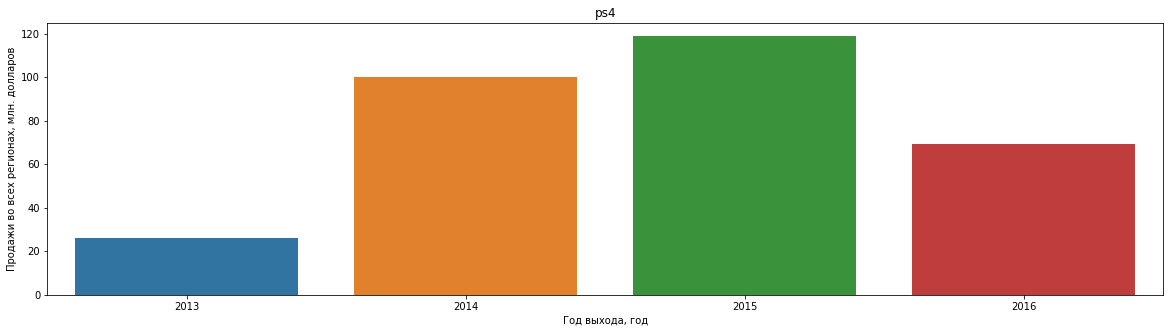

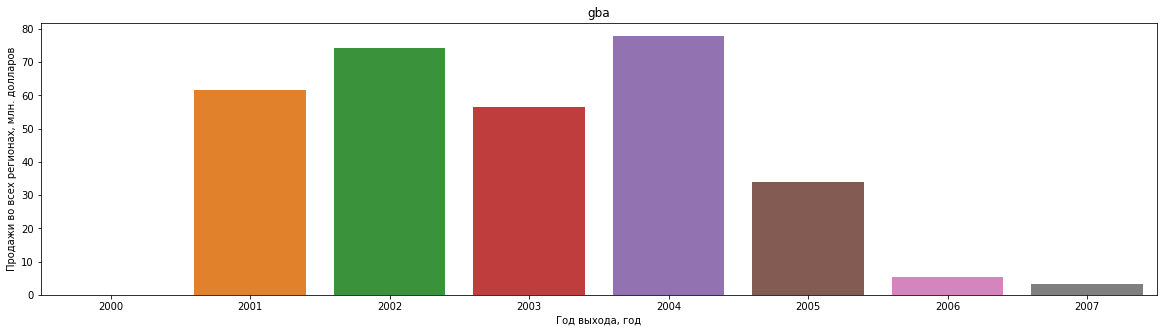

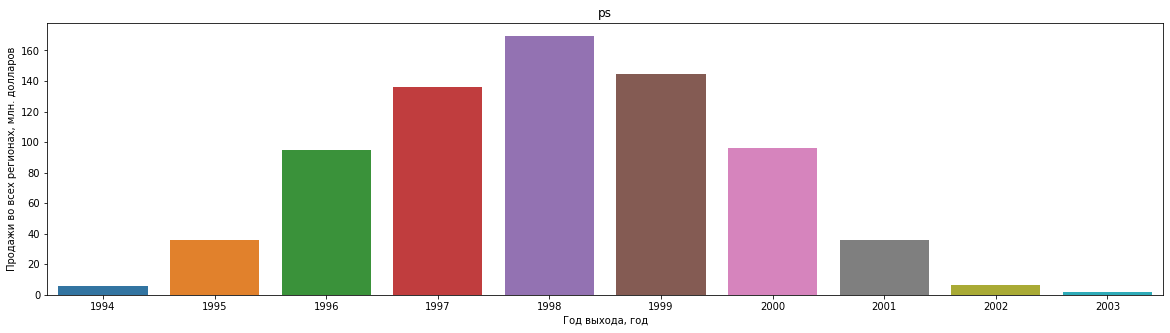

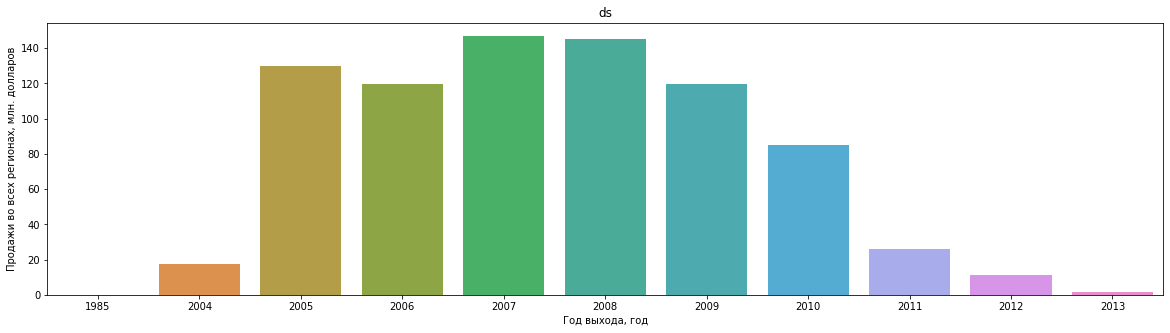

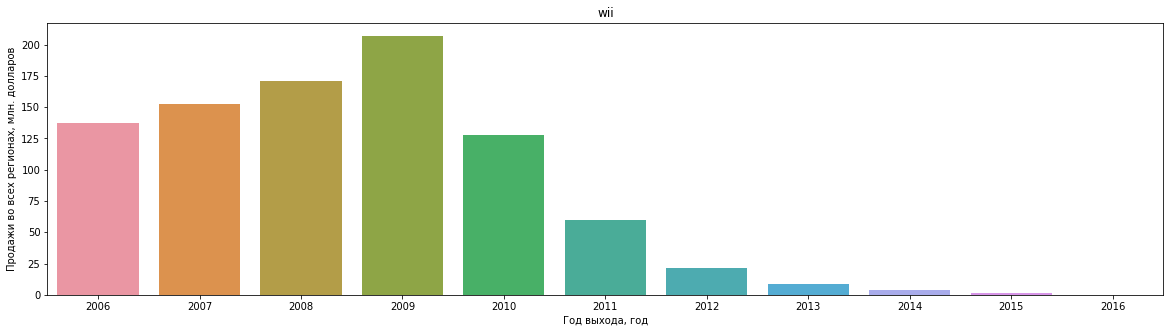

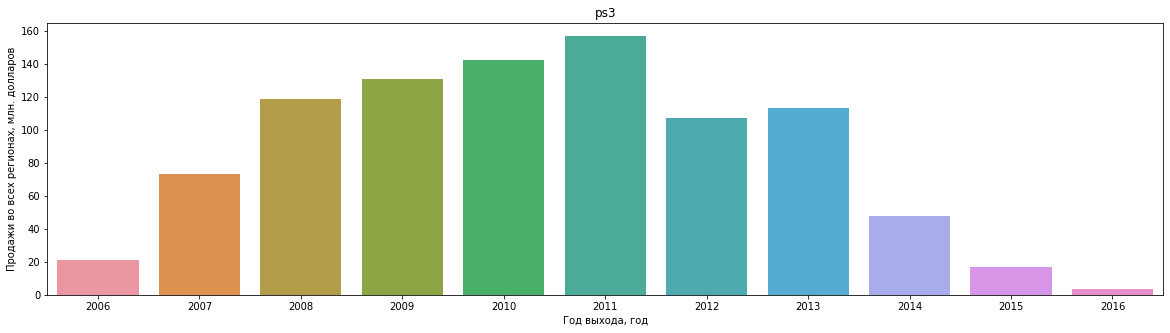

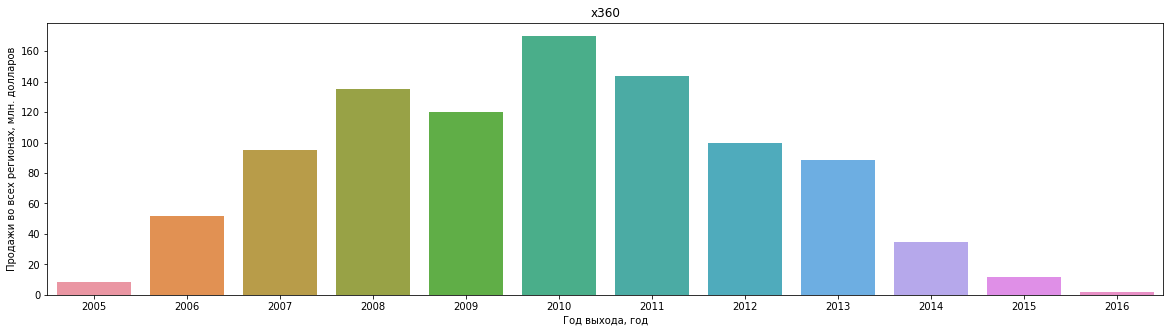

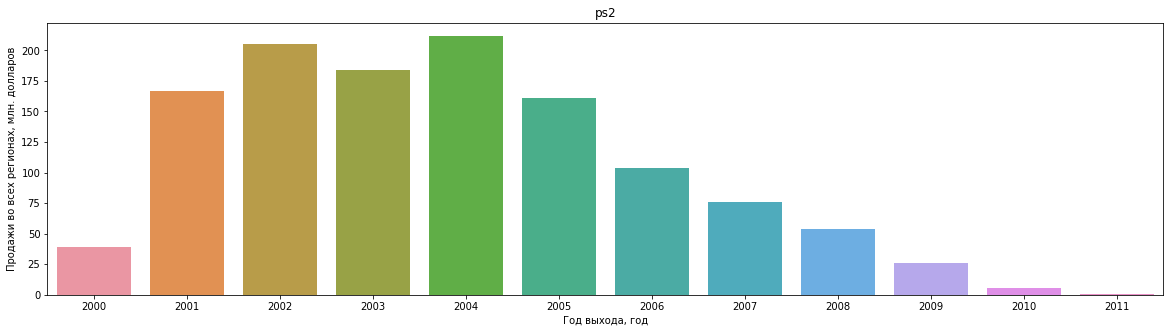

In [76]:
rcParams['figure.figsize'] = 20, 5
for platform in platform_name:
    tmp = df_for_graph.query('platform==@platform')
    tmp.rename(columns={'all_sales':'Продажи во всех регионах, млн. долларов', 'year_of_release':'Год выхода, год'}, inplace=True)
    plt.title(platform)
#     plt.xlabel('Год выхода')
#     plt.ylabel('Продажи во всех регионах, млн. долларов')
    sns.barplot(x="Год выхода, год", y="Продажи во всех регионах, млн. долларов", data=tmp)
    plt.show()

Исходя из графиков видно, что срок жизни популярных консолей примерно 10 лет. Чего нельзя сказать о pc, но продажи на данной платформе оставляют желать лучшего, т.к. основная проблема pc это пиратство. На мой взгляд для прогноза на 2017 надо смотреть на рынок промежутком в 4 года, т.е. с 2013 года. Странно, что в список не попал xbox one, но фильтрация по году исправит данную ситуацию.

In [21]:
games_upd = games.query('year_of_release > 2012')

In [78]:
games_upd.reset_index(drop=True,inplace=True)

Собираю датафрейм с разбивкой по годам и платформам для просмотра сумм по продажам во всех регионах

In [23]:
sales_by_year = games_upd.groupby(['year_of_release', 'platform'])[['all_sales']].sum().reset_index()

Получаю список платформ для цикла

In [24]:
platforms = sales_by_year['platform'].unique()

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
0              2013       3ds                                    56.57
11             2014       3ds                                    43.76
21             2015       3ds                                    27.78
31             2016       3ds                                    15.14


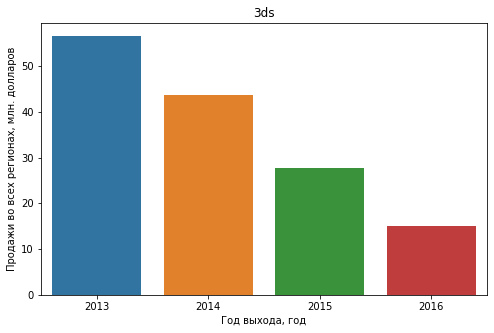

   Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
1             2013        ds                                     1.54


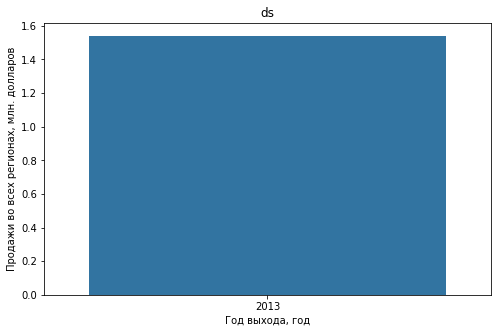

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
2              2013        pc                                    12.38
12             2014        pc                                    13.28
22             2015        pc                                     8.52
32             2016        pc                                     5.25


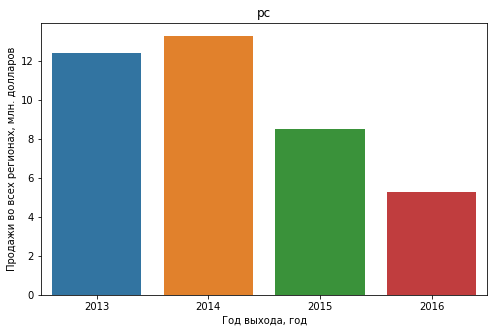

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
3              2013       ps3                                   113.25
13             2014       ps3                                    47.76
23             2015       ps3                                    16.82
33             2016       ps3                                     3.60


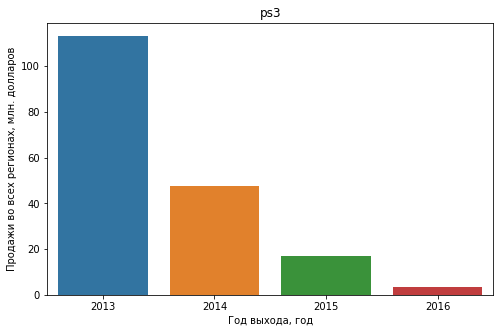

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
4              2013       ps4                                    25.99
14             2014       ps4                                   100.00
24             2015       ps4                                   118.90
34             2016       ps4                                    69.25


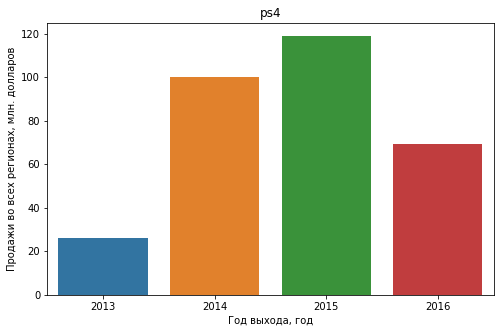

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
5              2013       psp                                     3.14
15             2014       psp                                     0.24
25             2015       psp                                     0.12


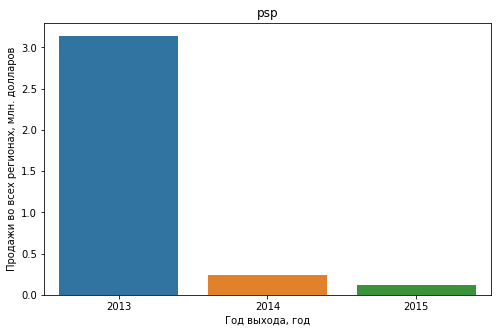

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
6              2013       psv                                    10.59
16             2014       psv                                    11.90
26             2015       psv                                     6.25
35             2016       psv                                     4.25


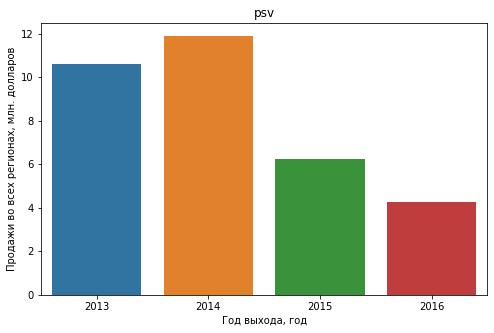

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
7              2013       wii                                     8.59
17             2014       wii                                     3.75
27             2015       wii                                     1.14
36             2016       wii                                     0.18


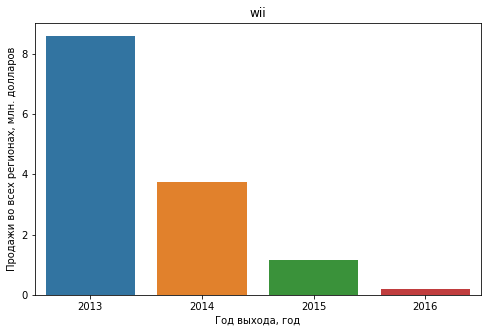

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
8              2013      wiiu                                    21.65
18             2014      wiiu                                    22.03
28             2015      wiiu                                    16.35
37             2016      wiiu                                     4.60


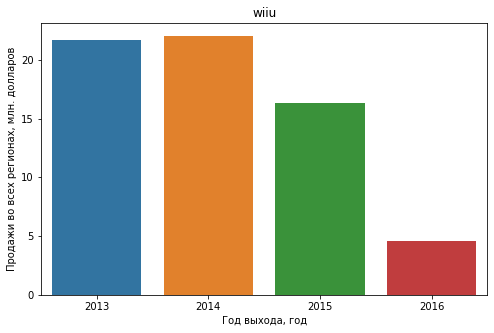

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
9              2013      x360                                    88.58
19             2014      x360                                    34.74
29             2015      x360                                    11.96
38             2016      x360                                     1.52


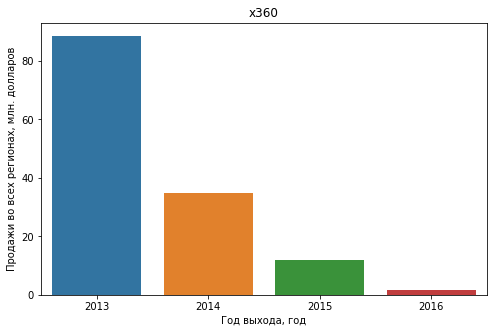

    Год выхода, год Платформа  Продажи во всех регионах, млн. долларов
10             2013      xone                                    18.96
20             2014      xone                                    54.07
30             2015      xone                                    60.14
39             2016      xone                                    26.15


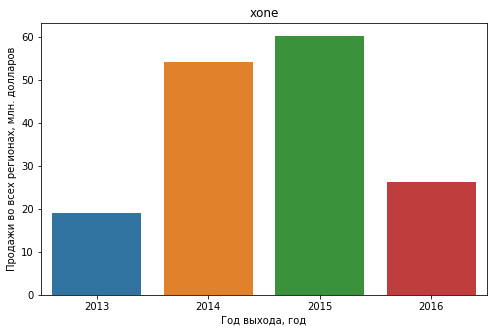

In [25]:
rcParams['figure.figsize'] = 8, 5
for platform in platforms:
    graph = sales_by_year.query('platform == @platform')
    graph.rename(columns={'all_sales':'Продажи во всех регионах, млн. долларов', 'platform':'Платформа', 'year_of_release':'Год выхода, год'}, inplace=True)
    print(graph)
    plt.title(platform)
    sns.barplot(x="Год выхода, год", y="Продажи во всех регионах, млн. долларов", data=graph)
    plt.show()

Как видно из графиков ни у одной из платформ нет тенденции роста, но если смотреть на суммарный объем продаж, то можно выделить 3: ps4 (как лидера продаж), 3ds и xbox one 

Отфильтрую исходный датафрейм для получения данных по нужным платформам и год больше 2012

In [26]:
games_filtered = games.query('year_of_release > 2012 and platform == "ps4" or platform == "3ds" or platform == "xone"').reset_index()

Далее строю диаграммы размаха по рассматреиваемым платформам и сумме проданных игр

0.8013775510204081

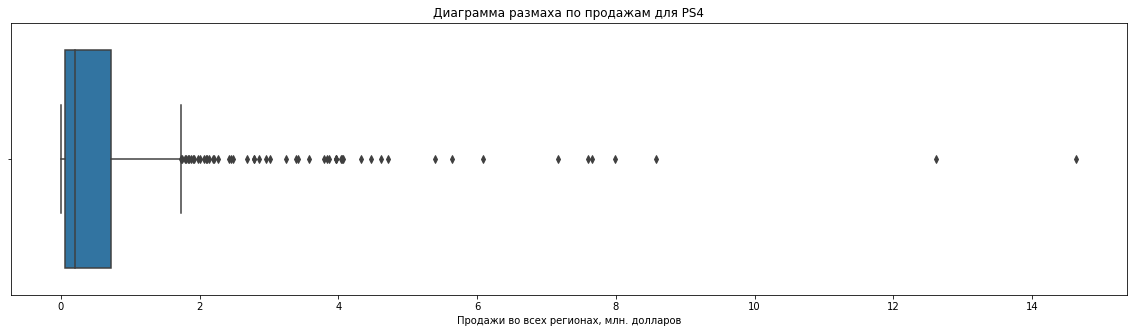

In [27]:
rcParams['figure.figsize'] = 20, 5
plt.title("Диаграмма размаха по продажам для PS4")
sns.boxplot(x=games_filtered.query('platform=="ps4"')['all_sales'])
plt.xlabel('Продажи во всех регионах, млн. долларов')
games_filtered.query('platform=="ps4"')['all_sales'].mean()

0.6450202429149797

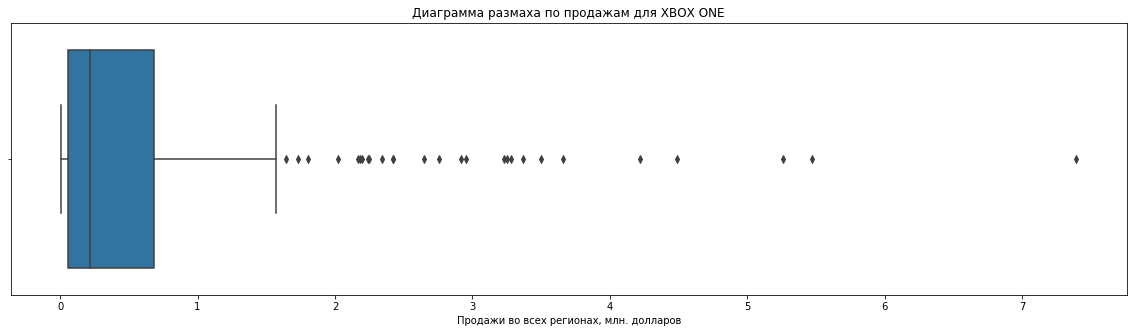

In [28]:
plt.title("Диаграмма размаха по продажам для XBOX ONE")
sns.boxplot(x=games_filtered.query('platform=="xone"')['all_sales'])
plt.xlabel('Продажи во всех регионах, млн. долларов')
games_filtered.query('platform=="xone"')['all_sales'].mean()

0.4980769230769232

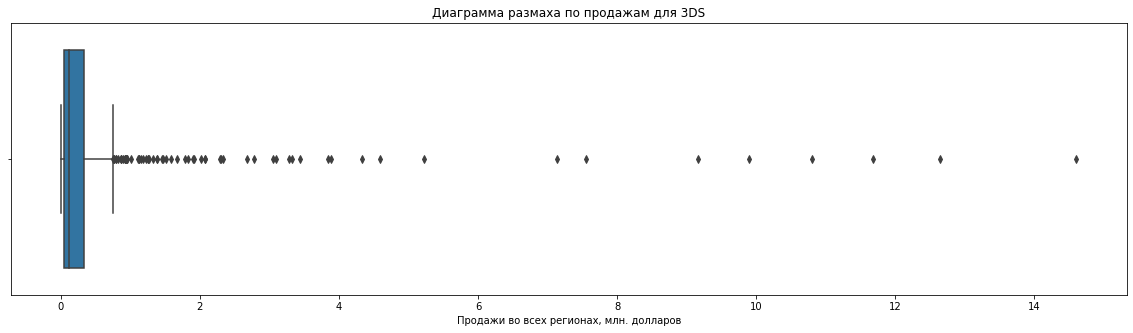

In [29]:
plt.title("Диаграмма размаха по продажам для 3DS")
sns.boxplot(x=games_filtered.query('platform=="3ds"')['all_sales'])
plt.xlabel('Продажи во всех регионах, млн. долларов')
games_filtered.query('platform=="3ds"')['all_sales'].mean()

Топ по средней продаваемости одной игры следующий
- ps4
- xbox one
- 3ds

Но некоторые игры на ps4 и 3ds принесли выручку в почти 15 млн долларов, в свою очередь на xbox one максимальная выручка была примерно в 8 млн долларов. Разница между платформами по средним продажам одной игры составляет примерно 160 тыс долларов. 

Строю диаграмму рассеивания и корелляцию между продажами и оценками критиков и пользователей


Корелляция для ps4
                                         Оценка критиков, 0-100  \
Оценка критиков, 0-100                                 1.000000   
Оценка пользователей, 0-10                             0.557654   
Продажи во всех регионах, млн. долларов                0.405895   

                                         Оценка пользователей, 0-10  \
Оценка критиков, 0-100                                     0.557654   
Оценка пользователей, 0-10                                 1.000000   
Продажи во всех регионах, млн. долларов                   -0.033625   

                                         Продажи во всех регионах, млн. долларов  
Оценка критиков, 0-100                                                  0.405895  
Оценка пользователей, 0-10                                             -0.033625  
Продажи во всех регионах, млн. долларов                                 1.000000  


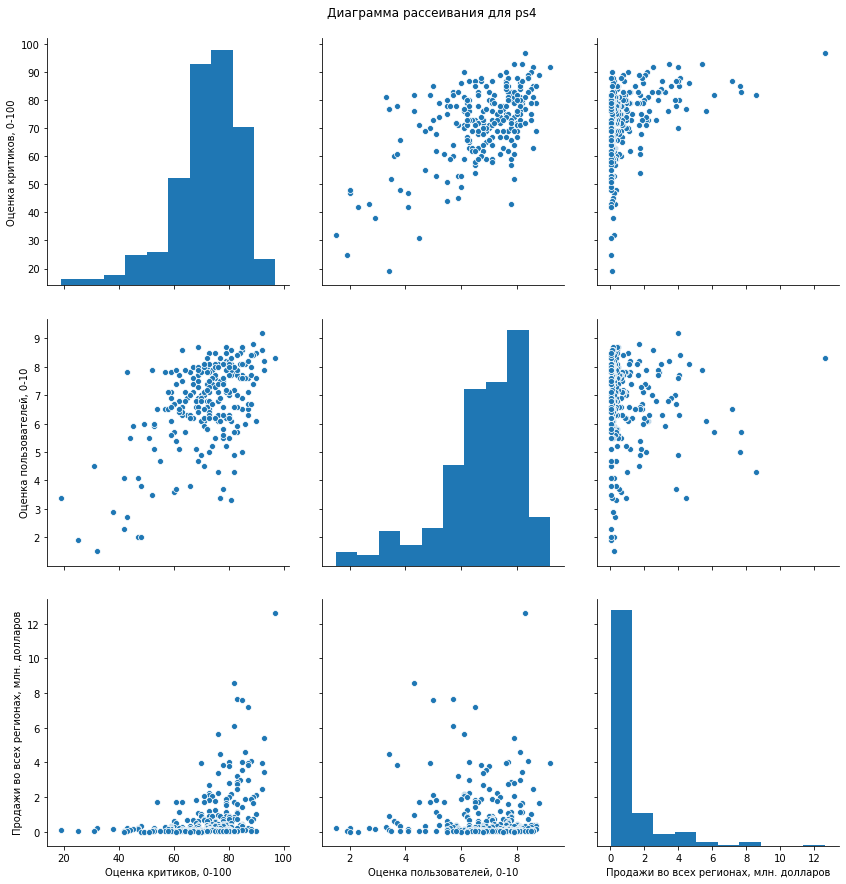


Корелляция для xone
                                         Оценка критиков, 0-100  \
Оценка критиков, 0-100                                 1.000000   
Оценка пользователей, 0-10                             0.472462   
Продажи во всех регионах, млн. долларов                0.410422   

                                         Оценка пользователей, 0-10  \
Оценка критиков, 0-100                                     0.472462   
Оценка пользователей, 0-10                                 1.000000   
Продажи во всех регионах, млн. долларов                   -0.094003   

                                         Продажи во всех регионах, млн. долларов  
Оценка критиков, 0-100                                                  0.410422  
Оценка пользователей, 0-10                                             -0.094003  
Продажи во всех регионах, млн. долларов                                 1.000000  


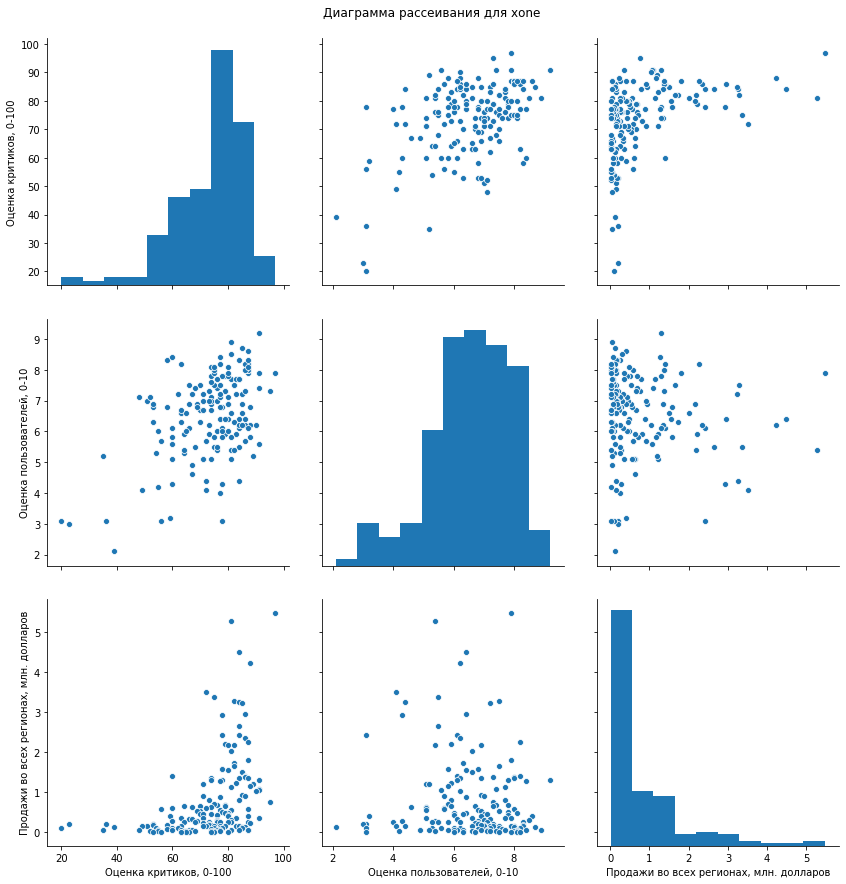


Корелляция для 3ds
                                         Оценка критиков, 0-100  \
Оценка критиков, 0-100                                 1.000000   
Оценка пользователей, 0-10                             0.744168   
Продажи во всех регионах, млн. долларов                0.339824   

                                         Оценка пользователей, 0-10  \
Оценка критиков, 0-100                                     0.744168   
Оценка пользователей, 0-10                                 1.000000   
Продажи во всех регионах, млн. долларов                    0.233403   

                                         Продажи во всех регионах, млн. долларов  
Оценка критиков, 0-100                                                  0.339824  
Оценка пользователей, 0-10                                              0.233403  
Продажи во всех регионах, млн. долларов                                 1.000000  


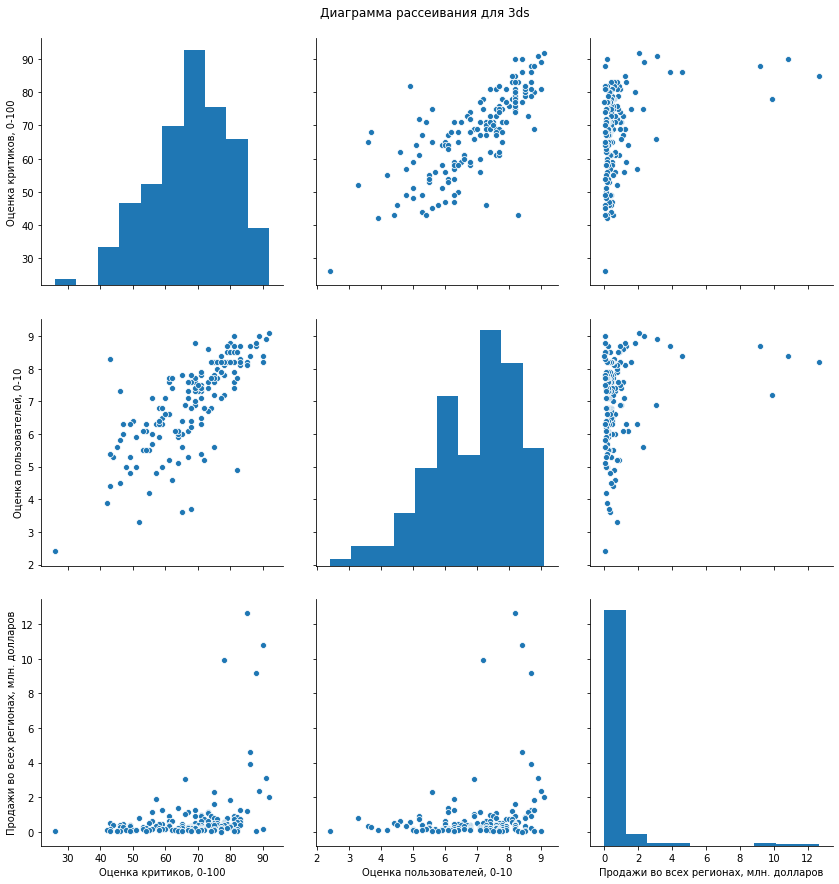

In [74]:
rcParams['figure.figsize'] = 15, 15
platforms = ['ps4', 'xone', '3ds']
for platform in platforms:
    print("\nКорелляция для", platform)
    platform_corr = games_filtered.query('platform == @platform and critic_score > 0 and user_score != "tbd" and user_score != -1')
    platform_corr.rename(columns={'user_score':'Оценка пользователей, 0-10', 'critic_score':'Оценка критиков, 0-100', 'all_sales':'Продажи во всех регионах, млн. долларов'}, inplace=True)
    platform_corr['Оценка пользователей, 0-10'] = platform_corr['Оценка пользователей, 0-10'].astype('float')
    platform_corr_multi = platform_corr.loc[:, ['Оценка критиков, 0-100', 'Оценка пользователей, 0-10', 'Продажи во всех регионах, млн. долларов']]
    print(platform_corr_multi.corr())
    #print(platform)
    #pd.plotting.scatter_matrix(platform_corr_multi, figsize=(12, 12))

    #sns.pairplot(platform_corr_multi, corner=True)
    g = sns.pairplot(platform_corr_multi, height=4)
    title = 'Диаграмма рассеивания для %s' % (platform)
    g.fig.suptitle(title, y=1.02)
    plt.show()

Уровен продаж игр на конкретной платформе зависит от оценки критиков, оценка пользлователей на продажи не оказывает особое влияние, и это логично, так как критики могут поставить оценку до старта продаж и тем самым решить судьбу той или иной игры, пользователь же может поставить оценку только после покупки. При этом оценки критиков влияют не только на продажи, но и на оценки пользователей 

Далее нужно посмотреть какие жанры на каких платформах приносят больше всего денег

In [31]:
sales_by_genre = games_filtered.groupby(['genre', 'platform'])[['all_sales']].sum().reset_index()

In [32]:
max_sales = sales_by_genre['all_sales'].max()
sales_by_genre.query('all_sales==@max_sales')

,genre,platform,all_sales
1,action,ps4,96.1


In [33]:
min_sales = sales_by_genre['all_sales'].min()
sales_by_genre.query('all_sales==@min_sales')

,genre,platform,all_sales
16,puzzle,ps4,0.02


In [34]:
sales_by_genre.sort_values(by='all_sales').tail(5)

,genre,platform,all_sales
0,action,3ds,58.24
25,shooter,xone,60.33
20,role-playing,3ds,84.23
24,shooter,ps4,88.56
1,action,ps4,96.10


In [35]:
sales_by_genre.sort_values(by='all_sales').query('platform == "ps4"')

,genre,platform,all_sales
16,puzzle,ps4,0.02
33,strategy,ps4,0.62
27,simulation,ps4,1.23
4,adventure,ps4,6.34
13,platform,ps4,7.69
10,misc,ps4,8.19
7,fighting,ps4,8.65
18,racing,ps4,12.14
21,role-playing,ps4,28.99
30,sports,ps4,55.61


In [36]:
sales_by_genre.sort_values(by='all_sales').query('platform == "3ds"')

,genre,platform,all_sales
23,shooter,3ds,1.29
32,strategy,3ds,2.09
3,adventure,3ds,4.92
15,puzzle,3ds,5.57
29,sports,3ds,6.17
6,fighting,3ds,10.56
9,misc,3ds,10.99
17,racing,3ds,14.96
26,simulation,3ds,27.45
12,platform,3ds,32.53


In [37]:
sales_by_genre.sort_values(by='all_sales').query('platform == "xone"')

,genre,platform,all_sales
34,strategy,xone,0.42
28,simulation,xone,0.69
14,platform,xone,0.93
8,fighting,xone,2.45
5,adventure,xone,2.68
11,misc,xone,7.43
19,racing,xone,9.79
22,role-playing,xone,10.55
31,sports,xone,26.74
2,action,xone,37.31


Самые продаваемые игры - action на ps4, хуже всего продаются пазлы на той же ps4. В топ 5 входят 3 жанра - action, shooter и role-playing.  

Результаты в разбивке по платформам.

ps4: лучшие продажи у экшнов и шутеров, худшие у стратегий и пазлов

3ds: лучшие продажи у ролевых игр и экшнов, худшие у стратегий и шутеров

xbox one: лучшие продажи у шутеров и экшнов, худшие у симуляторов и стратегий

<a id='researchanalysres'></a>
<H4>Выводы:</H4>

- Начиная с 91 года по 02 количество игр растет, пик выпуска игр был в 08-09 годах
- Срок жизни популярных консолей примерно 10 лет
- Игры на ПК продаются плохо (скорей всего связано с пиратством)
- Лучшие платформы по продажам: ps4 (лидер продаж), 3ds и xbox one
- Некоторые игры на ps4 и 3ds принесли прибыль в почти 15 млн долларов
- xbox one самая прибыльная игра принесла доход почти в 8 млн долларов 
- Разница между платформами по средним продажам одной игры составляет примерно 160 тыс долларов.
- Уровень продаж игр на конкретной платформе зависит от оценки критиков
- Оценка пользлователей на продажи не оказывае особое влияние
- Оценки критиков влияют не только на продажи, но и на оценки пользователей
- Самые продаваемые игры - action на ps4, хуже всего продаются пазлы на той же ps4. В топ 5 входят 3 жанра - action, shooter и role-playing.
- ps4: лучшие продажи у экшнов и шутеров, худшие у стратегий и пазлов
- 3ds: лучшие продажи у ролевых игр и экшнов, худшие у стратегий и шутеров
- xbox one: лучшие продажи у шутеров и экшнов, худшие у симуляторов и стратегий

<a id='userportrait'></a>
<H2>Портрет пользователя</H2>

Далее необходимо посмотреть как продаются игры на платформы по разным регионам

In [38]:
sales_by_na_sales = games.groupby('platform')[['na_sales']].sum().reset_index()
sales_by_eu_sales = games.groupby('platform')[['eu_sales']].sum().reset_index()
sales_by_jp_sales = games.groupby('platform')[['jp_sales']].sum().reset_index()
sales_by_all_sales = games.groupby('platform')[['all_sales']].sum().reset_index()
by_sales = sales_by_na_sales.merge(sales_by_eu_sales, how='left')
by_sales = by_sales.merge(sales_by_jp_sales, how='left')
by_sales = by_sales.merge(sales_by_all_sales, how='left')
by_sales.sort_values(by='all_sales', inplace=True)

Расчитываю максимальную и суммарную продажу по рынку Северной Америки

In [39]:
na_sales_max = by_sales['na_sales'].max()
print("Суммарные продажи игр на рынке Северной Америки:", by_sales['na_sales'].sum())

Суммарные продажи игр на рынке Северной Америки: 4400.569999999989


Тоже самое делаю для рынка Европы

In [40]:
eu_sales_max = by_sales['eu_sales'].max()
print("Суммарные продажи игр на рынке Европы: ", by_sales['eu_sales'].sum())

Суммарные продажи игр на рынке Европы:  2424.13999999999


И для рынка Японии

In [41]:
jp_sales_max = by_sales['jp_sales'].max()
print("Суммарные продажи игр на рынке Японии: ", by_sales['jp_sales'].sum())

Суммарные продажи игр на рынке Японии:  1297.3400000000013


Далее нахожу самую прибульную платформу в Северной Америке

In [42]:
by_sales.query('na_sales == @na_sales_max')

,platform,na_sales,eu_sales,jp_sales,all_sales
28,x360,602.47,270.76,12.43,971.42


Тоже самое для рынка Европы

In [43]:
by_sales.query('eu_sales == @eu_sales_max')

,platform,na_sales,eu_sales,jp_sales,all_sales
16,ps2,583.84,339.29,139.2,1255.77


И для рынка Японии

In [44]:
by_sales.query('jp_sales == @jp_sales_max')

,platform,na_sales,eu_sales,jp_sales,all_sales
4,ds,382.4,188.89,175.57,806.12


После нахожу среднее по общим продажам для разбивки таблицы

In [45]:
mean_all_sales = by_sales['all_sales'].mean()

И вывожу сначала платформы, которые принесли большие продажи

In [46]:
good_platform = by_sales.query('all_sales > @mean_all_sales').reset_index()
print("Платформы, которые принесли выручку больше среднего")
good_platform

Платформы, которые принесли выручку больше среднего


,index,platform,na_sales,eu_sales,jp_sales,all_sales
0,19,psp,109.17,66.68,76.78,294.05
1,18,ps4,108.74,141.09,15.96,314.14
2,6,gba,187.54,75.25,47.33,317.85
3,15,ps,336.52,213.61,139.82,730.86
4,4,ds,382.40,188.89,175.57,806.12
5,25,wii,496.90,262.21,69.33,907.51
6,17,ps3,393.49,330.29,80.19,939.65
7,28,x360,602.47,270.76,12.43,971.42
8,16,ps2,583.84,339.29,139.20,1255.77


И меньшие

In [47]:
good_platform = by_sales.query('all_sales < @mean_all_sales').reset_index()
print("Платформы, которые принесли выручку меньше среднего")
good_platform

Платформы, которые принесли выручку меньше среднего


,index,platform,na_sales,eu_sales,jp_sales,all_sales
0,14,pcfx,0.00,0.00,0.03,0.03
1,9,gg,0.00,0.00,0.04,0.04
2,1,3do,0.00,0.00,0.10,0.10
3,24,tg16,0.00,0.00,0.16,0.16
4,27,ws,0.00,0.00,1.42,1.42
5,12,ng,0.00,0.00,1.44,1.44
6,22,scd,1.00,0.36,0.45,1.86
7,3,dc,5.43,1.69,8.56,15.95
8,8,gen,19.27,5.52,2.67,28.35
9,21,sat,0.72,0.54,32.26,33.59


Больше всего дохода принесли игры на ps2, меньше всего на pcfx. 

Суммарные продажи по Северной Америке равны 4400.5 млн. доларов. Наибольшие продажи в этом регионе были на x360 (602.47)

Суммарные продажи по Европе равны 2424.1 млн. доларов. Наибольшие продажи в этом регионе были на ps2 (339.29)

Суммарные продажи по Японии равны 1297.3 млн. доларов. Наибольшие продажи в этом регионе были на ds (175.57)

Далее нужно посмотреть как жанр влияет на продажи в разных регионах 

In [48]:
genre_by_na_sales = games.groupby('genre')[['na_sales']].sum().reset_index()
genre_by_eu_sales = games.groupby('genre')[['eu_sales']].sum().reset_index()
genre_by_jp_sales = games.groupby('genre')[['jp_sales']].sum().reset_index()
genre_by_all_sales = games.groupby('genre')[['all_sales']].sum().reset_index()
genre_by_sales = genre_by_na_sales.merge(genre_by_eu_sales, how='left')
genre_by_sales = genre_by_sales.merge(genre_by_jp_sales, how='left')
genre_by_sales = genre_by_sales.merge(genre_by_all_sales, how='left')
genre_by_sales.sort_values(by='all_sales', inplace=True)
genre_by_sales.reset_index(inplace=True, drop=True)

Расчитываю максимальную, минимальную и суммарную продажу по рынку Северной Америки

In [49]:
na_genre_sales_max = genre_by_sales['na_sales'].max()
na_genre_sales_min = genre_by_sales['na_sales'].min()
print('Суммарные продажи по рынку Северной Америки: ', genre_by_sales['na_sales'].sum())

Суммарные продажи по рынку Северной Америки:  4400.569999999979


Тоже самое для рынка Европы

In [50]:
eu_genre_sales_max = genre_by_sales['eu_sales'].max()
eu_genre_sales_min = genre_by_sales['eu_sales'].min()
("Суммарные продажи по Европе: ", genre_by_sales['eu_sales'].sum())

('Суммарные продажи по Европе: ', 2424.139999999979)

И Японии

In [51]:
jp_genre_sales_max = genre_by_sales['jp_sales'].max()
jp_genre_sales_min = genre_by_sales['jp_sales'].min()
("Суммарные продажи по Японии: ",genre_by_sales['jp_sales'].sum())

('Суммарные продажи по Японии: ', 1297.3399999999997)

Нахожу жанр с максимальным уровнем продаж в Северной Америке

In [52]:
genre_by_sales.query('na_sales == @na_genre_sales_max')

,genre,na_sales,eu_sales,jp_sales,all_sales
11,action,879.01,519.13,161.43,1744.17


Нахожу жанр с минимальным уровнем продаж в Северной Америке

In [53]:
genre_by_sales.query('na_sales == @na_genre_sales_min')

,genre,na_sales,eu_sales,jp_sales,all_sales
0,strategy,68.55,45.17,49.66,174.23


Аналогично для рынка Европы

In [54]:
genre_by_sales.query('eu_sales == @eu_genre_sales_max')

,genre,na_sales,eu_sales,jp_sales,all_sales
11,action,879.01,519.13,161.43,1744.17


In [55]:
genre_by_sales.query('eu_sales == @eu_genre_sales_min')

,genre,na_sales,eu_sales,jp_sales,all_sales
0,strategy,68.55,45.17,49.66,174.23


И для японского рынка

In [56]:
genre_by_sales.query('jp_sales == @jp_genre_sales_max')

,genre,na_sales,eu_sales,jp_sales,all_sales
8,role-playing,330.81,188.71,355.41,934.56


In [57]:
genre_by_sales.query('jp_sales == @jp_genre_sales_min')

,genre,na_sales,eu_sales,jp_sales,all_sales
9,shooter,592.24,317.34,38.76,1052.45


In [58]:
genre_by_sales

,genre,na_sales,eu_sales,jp_sales,all_sales
0,strategy,68.55,45.17,49.66,174.23
1,adventure,105.26,63.54,52.30,237.59
2,puzzle,122.87,50.01,57.31,242.57
3,simulation,181.92,113.52,63.80,389.97
4,fighting,223.36,100.33,87.48,447.53
5,racing,359.35,236.51,56.71,728.67
6,misc,407.27,212.74,108.11,802.51
7,platform,445.50,200.35,130.83,827.77
8,role-playing,330.81,188.71,355.41,934.56
9,shooter,592.24,317.34,38.76,1052.45


Больше всего дохода принесли экшн игры, меньше всего стратегии. 

Наибольшие продажи в Северной Америке были в жанре экшн (879.01), хуже всего продавались стратегии (68.55)

Наибольшие продажи в Европе были в жанре экшн (519.13), хуже всего продавались стратегии (45.17)

Наибольшие продажи в Японии были в жанре ролевых игр (355.41), хуже всего продавались шутеры (38.76)

Я решил заполнить пропуски в рейтинге рейтингом RP, который означает что рейтинг этой игре не поставлен

In [59]:
games['rating'].fillna(value='RP', inplace=True)

Далее я фильтрую данные по рейтингу и откидываю рейтинг RP, так как по сути он не определен и для ответа на вопрос он не важен

Так же я создаю вспомогательный датафрейм с рейтингами для их интерпретации 

In [60]:
games_rating_filtered = games.query('rating != "RP"')
rating = pd.DataFrame({'rating': ['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'T'], 'description': ['только для взрослых', 'для всех', '10+', '3+ (устаревшее)', 'для всех (устаревшее)', '17+', '13+']})
rating_by_na_sales = games_rating_filtered.groupby('rating')[['na_sales']].sum().reset_index()
rating_by_eu_sales = games_rating_filtered.groupby('rating')[['eu_sales']].sum().reset_index()
rating_by_jp_sales = games_rating_filtered.groupby('rating')[['jp_sales']].sum().reset_index()
rating_by_all_sales = games_rating_filtered.groupby('rating')[['all_sales']].sum().reset_index()
rating_by_sales = rating_by_na_sales.merge(rating_by_eu_sales, how='left')
rating_by_sales = rating_by_sales.merge(rating_by_jp_sales, how='left')
rating_by_sales = rating_by_sales.merge(rating_by_all_sales, how='left')
rating_by_sales = rating_by_sales.merge(rating, how='left')
rating_by_sales.sort_values(by='all_sales', inplace=True)
rating_by_sales

,rating,na_sales,eu_sales,jp_sales,all_sales,description
3,EC,1.53,0.11,0.00,1.75,3+ (устаревшее)
0,AO,1.26,0.61,0.00,1.96,только для взрослых
4,K-A,2.56,0.27,1.46,4.32,для всех (устаревшее)
2,E10+,353.32,188.52,40.20,655.60,10+
5,M,748.48,483.97,64.24,1473.79,17+
6,T,759.75,427.03,151.40,1493.35,13+
1,E,1292.99,710.25,198.11,2435.52,для всех


Больше всего дохода принесли игры с рейтингом E, меньше всего с рейтингом EC.

Наибольшие продажи в Северной Америке были с рейтингом Е (1292.99), меньше всего с рейтингом AO (1.26)

Наибольшие продажи в Европе были с рейтингом Е (710.25), меньше всего с рейтингом EC (0.11)

Наибольшие продажи в Японии были с рейтингом Е (198.11), меньше всего с рейтингом EC и AO (0)

<a id='userportraitres'></a>
<H4>Выводы</H4>

По платформам:

- Больше всего дохода принесли игры на ps2, меньше всего на pcfx.
- Суммарные продажи по Северной Америке равны 4400.5 млн. доларов. Наибольшие продажи в этом регионе были на x360 (602.47)
- Суммарные продажи по Европе равны 2424.1 млн. доларов. Наибольшие продажи в этом регионе были на ps2 (339.29)
- Суммарные продажи по Японии равны 1297.3 млн. доларов. Наибольшие продажи в этом регионе были на ds (175.57)

По жанрам:

- Больше всего дохода принесли экшн игры, меньше всего стратегии.
- Наибольшие продажи в Северной Америке были в жанре экшн (879.01), хуже всего продавались стратегии (68.55)
- Наибольшие продажи в Европе были в жанре экшн (519.13), хуже всего продавались стратегии (45.17)
- Наибольшие продажи в Японии были в жанре ролевых игр (519.13), хуже всего продавались шутеры (38.76)

По рейтингам:

- Больше всего дохода принесли игры с рейтингом E, меньше всего с рейтингом EC.
- Наибольшие продажи в Северной Америке были с рейтингом Е (1292.99), меньше всего с рейтингом AO (1.26)
- Наибольшие продажи в Европе были с рейтингом Е (710.25), меньше всего с рейтингом EC (0.11)
- Наибольшие продажи в Японии были с рейтингом Е (198.11), меньше всего с рейтингом EC и AO (0)

<a id='hypotheses'></a>
<H2>Гипотезы</H2>

<b>H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1 (алтернативная): Средние пользовательские рейтинги платформ Xbox One и PC разные</b>

Для начала создаю два датафрейма по платформам и откидываю оценки tbd (количество оценок менше трех) и игры с пропущенными значениями

#### Пояснение

Просто из формулировки гипотез в задании это было не понятно

In [61]:
xone_rating_mean = games.query('platform == "xone" and user_score != "tbd" and user_score != -1 and year_of_release > 2012')
pc_rating_mean = games.query('platform == "pc" and user_score != "tbd" and user_score != -1 and year_of_release > 2012')

После чего нужно проверить гипотезы

In [62]:
alpha = 0.05

results = st.ttest_ind(
     xone_rating_mean['user_score'].astype('float'),
     pc_rating_mean['user_score'].astype('float')
   
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось опровергнуть нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

<b>H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

H1 (алтернативная): Средние пользовательские рейтинги жанров Action и Sports разные</b>

Делаю тоже самое для проверки второй гипотезы

In [63]:
xone_rating_mean = games.query('genre == "action" and user_score != "tbd" and user_score != -1 and year_of_release > 2012')
pc_rating_mean = games.query('genre == "sports" and user_score != "tbd" and user_score != -1 and year_of_release > 2012')

In [64]:
results = st.ttest_ind(
     xone_rating_mean['user_score'].astype('float'),
     pc_rating_mean['user_score'].astype('float')
   
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Средняя оценка для двух жанров разыне

<a id='hypothesesres'></a>
<H4>Выводы</H4>

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средняя оценка для игр в жанре экшн и спорт разная

<a id='findings'></a>
<H2>Выводы по работе</H2>

<b>Пункт 1.</b> Анализ проблем с данными

В ходе первичного просмотра данных были выявлены следующие проблемы:
>Пропуски в полях:
>- Name: 2 значения
>- Year_of_Release: 269 значений
>- Genre: 2 значения
>- Critic_Score: 8578 значений
>- User_Score: 6701 значений
>- Rating: 6766 значений
>
>Также есть проблемы с типами данных:
>- Year_of_Release: представлен в float, но так как это год, то лучше представить значение в int


<b>Пункт 2.</b> Предобработка данных

Изначально пытался найти статистические зависимости, закодировав категориалные признаки, для заполнения пропусков в данных (что вкорне не верно), но ввиду отсутствия было решено заполнить все пропуски нетипичными значениями для удобной фильтрации данных. Так же все строковые значения (кроме жанра) были приведены к нижнему регистру

<b>Пункт 3.</b> Исследовательский анализ данных

В ходе исследовательского анализа данных было выявленно несколько интересных факов, вот некоторые из них:
>- Начиная с 1991 года по 2002 количество игр растет, пик выпуска игр был в 2008-09 годах
>- Срок жизни популярных консолей примерно 10 лет
>- Игры на ПК продаются плохо (скорей всего связано с пиратством)
>- Уровень продаж игр на конкретной платформе зависит от оценки критиков
>- Оценки критиков влияют не только на продажи, но и на оценки пользователей
>- ps4: лучшие продажи у экшнов и шутеров, худшие у стратегий и пазлов
>- 3ds: лучшие продажи у ролевых игр и экшнов, худшие у стратегий и шутеров
>- xbox one: лучшие продажи у шутеров и экшнов, худшие у симуляторов и стратегий

За полным списком интересных фактов прошу по [ссылке](#researchanalysres)

<b>Пункт 4.</b> Составление портрета пользователя

В данной работе рассматривалось несколко аспектов, которые так или иначе влияют на продажи в таких регионах как Северная Америка, Европа и Япония. 
- Лидер продаж среди платформ - ps2
- Хуже всего продавались игры на pcfx
- Больше всего продаж принесли игры в жанре экшн, меньше всего - в жанре стратегия
- Лидер продаж - Северная Америка
- Наиболее популярная платформа в Северной Америке - xbox 360, в Европе - ps2, в Японии - ds
- Наиболее популярный жанр в Северной Америке и Европе - экшн, в Японии - RPG
- Наименее популярный жанр в Северной Америке и Европе - стратегии, в Японии - шутеры
- Лучше всего продаются игры с рейтингом Е

<b>Пункт 5.</b> Проверка гипотез
В ходе проверки гипотез, указаных [здесь](#hypotises) средние пользовательские рейтинги платформ Xbox One и PC одинаковые, а средняя оценка для игр в жанре экшн и спорт разная

Исходя из всего вышесказанного для магазина "Стримчик" можно сделать следующие <b>рекомендации</b>: 

- Лучше всего сделать упор на игры на 3 платформах: ps4, xbox one и 3ds
- В плане жанров лучше всего сделать упор на action, shooter и role-playing.
- Лучше всего продаюся игры с рейтингим Е и жанром экшн или ролевые игры.